# Implement a custom Autoencoder with Koopman layer

## Version Control

Short Term To Do:
1) Consider output activation function to be more robust than
2) Plot eigenfunctions & save
3) Constraining K
4) Validation data has different batch size. Address when HP training

Long Term To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Change training inference vs testing inference
5) Address gradient issue K^m.. Gradient is not taking account that propagation..

Note:
If you see a warning with koopman weight has no graident: reinitialize the model class object and run training directly. Do not build it before training.


## Setup

In [28]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time 
import os

In [29]:
# Import hyperparameter tuning
import keras_tuner as kt
hp = kt.HyperParameters()

In [30]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [350]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [31]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [101]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 1024 #total number of trajectories in the dataset

batch_size = int(512) # Number of snapshots in each batch
#numTraj_batch = int(batch_size/trajLength)
numTraj_batch = int(batch_size/trajLength)
input_dim = 2

num_batches = 128 ## num_batches = trajLength*numTraj/batch_size (max = 128)

In [33]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train[0:batch_size*num_batches], tf.float32)
validation_data = tf.cast(discrete_validation[0:batch_size*num_batches], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(discrete_test, tf.float32)

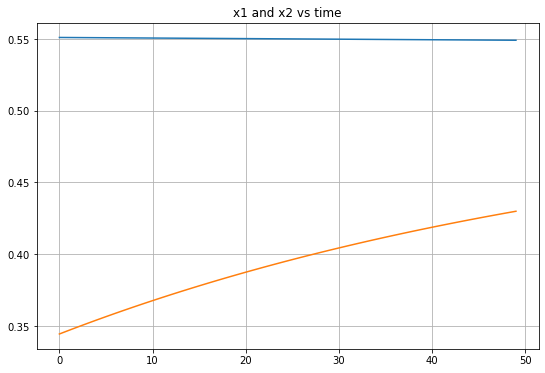

In [34]:
x_train = train_data[0:50,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

## Define the model

### Encoder

In [35]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [36]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder to take to lifted dimension w/ one output
    """
    def __init__(self, hp, name=None):
        """
        Initializes arbritrary layers of different unit size for encoder
        
        Parameter:
        ----------
        hp: Hyperparameter from keras
        name: String
            name of model
        """
        super(EncoderModel, self).__init__(name=name)
        self.encLayerLength = hp.Int("encLayerLength", min_value=2, max_value=5, step=1)
        self.encLayerDict = {}
        self.encActDict = {}
        for i in range(self.encLayerLength):
            self.encLayerDict["encLayer" + str(i)] = EncoderLayer(hp.Choice("enc_units_"+str(i),[16, 32, 64]))
            self.encActDict["encActLayer" + str(i)] = tf.keras.layers.Activation(hp.Choice("enc_act_"+str(i),['relu','elu']))
                                                        

    def call(self, input):
        z = input # Final layer of encoder is in lifted dimension
        for (key1,enc), (key2,encAct) in zip(self.encLayerDict.items(), self.encActDict.items()):
            z = enc(z)
            z = encAct(z)
        return z

### Koopman

In [75]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 #K = tf.zeros([latent_dim, latent_dim], dtype=tf.float32)
                 
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [76]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

### Decoder

In [77]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [78]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, hp, outputDim=2, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.decLayerDict = {}
        self.decActDict = {}
        self.decLayerLength = hp.Int("decLayerLength", min_value=2, max_value=5, step=1)
        for i in range(self.decLayerLength):
            self.decLayerDict["decLayer" + str(i)] = DecoderLayer(hp.Choice("dec_units_"+str(i),[16, 32, 64]))
            self.decActDict["decActLayer" + str(i)] = tf.keras.layers.Activation(hp.Choice("dec_act_"+str(i),['relu','elu']))
        self.outputLayer = DecoderLayer(outputDim)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        for (key1,dec),(key2,decAct) in zip(self.decLayerDict.items(), self.decActDict.items()):
            z, z2_hat, z2_tilde = dec(z, z2_hat, z2_tilde)
            z = decAct(z)
            z2_hat = decAct(z2_hat)
            z2_tilde = decAct(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        x_hat = tf.nn.elu(x_hat)
        x2_hat = tf.nn.elu(x2_hat)
        x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

### Koopman Autoencoder

In [79]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, hp, trajLength, numTraj, outputDim=2, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel(hp)
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel(hp, outputDim)

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

## Hyperparameter Tuning

In [1]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 


    def build(self, hp):
        koopmanAEModel = Koopman_AE_Model(hp, self.trajLength, self.numtraj_batch)
        return koopmanAEModel


    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 1
        alpha2 = 1e-5
        alpha3 = 1e-10

        x2 = []
        for i in range(self.numtraj_batch):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        x2 = tf.reshape(x2, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))

        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS     #########################################################


    def graphPlot(self, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_%d_Epoch_%d" % (epochNum, self.graphCounter)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close()  


    ###############################################     FIT FUNCTION        #########################################################


    def fit(self, hp, model, x, y, validation_data, batch_size, callbacks=None):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 10
        

        ############################################### TRAINING FUNCTIONS #######################################################

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                reconstruction, prediction, linearity = model(x_batch_train)

                # total avg loss for each batch
                batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                batch_train_loss_list.append(batch_train_loss)

            grads = tape.gradient(batch_train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            return batch_train_loss

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val, linearity_val = model(x_batch_val)
            
            batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
            batch_validation_loss_list.append(batch_validation_loss)

            epoch_loss_metric.update_state(batch_validation_loss)
            return batch_validation_loss

        ################################################# LOOPING BATCHES #####################################################


        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                batch_train_loss = run_train_step(x_batch_train, y_batch_train)
                
                # Log every 100 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(batch_train_loss))
                    )
            
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/num_batches
            epoch_train_loss.append(avg_train_loss)

            print(
                    "Average training loss at epoch %d: %.4f"
                    % (epoch, float(avg_train_loss))
                )
            print("Time taken: %.2fs" % (time.time() - start_time))

        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                batch_validation_loss = run_val_step(x_batch_val, y_batch_val)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/num_batches)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            print("Time taken: %.2fs" % (time.time() - start_time))
            print("Sum of Koopman Layer weights: %0.3f" % np.sum(model.koopman.get_weights()[0]))
            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
            self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)


        self.graphPlot(epoch_train_loss, epoch_validation_loss)
        # Return the evaluation metric value
        return best_epoch_val_loss

NameError: name 'kt' is not defined

In [99]:
hypermodel = MyHyperModel(input_dim, batch_size, num_batches)
tuner = kt.RandomSearch(
    objective=kt.Objective("my_metric", "min"),
    max_trials=1,
    hypermodel=hypermodel,
    directory="results",
    project_name="custom_training2",
    overwrite=True,
)

In [ ]:
tuner.search(x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)

In [ ]:
tuner.results_summary()

Results summary
Results in results\custom_training1
Showing 10 best trials
Objective(name='my_metric', direction='min')
Trial summary
Hyperparameters:
encLayerLength: 4
enc_units_0: 16
enc_act_0: relu
enc_units_1: 32
enc_act_1: elu
enc_units_2: 32
enc_act_2: relu
decLayerLength: 4
dec_units_0: 16
dec_act_0: relu
dec_units_1: 16
dec_act_1: elu
dec_units_2: 16
dec_act_2: relu
enc_units_3: 16
enc_act_3: relu
dec_units_3: 16
dec_act_3: relu
learning_rate: 0.001
Score: 0.3837232291698456


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'encLayerLength': 5, 'enc_units_0': 32, 'enc_act_0': 'relu', 'enc_units_1': 16, 'enc_act_1': 'elu', 'enc_units_2': 16, 'enc_act_2': 'relu', 'decLayerLength': 3, 'dec_units_0': 16, 'dec_act_0': 'elu', 'dec_units_1': 64, 'dec_act_1': 'elu', 'dec_units_2': 32, 'dec_act_2': 'elu', 'enc_units_3': 32, 'enc_act_3': 'relu', 'learning_rate': 0.009275159422772563, 'enc_units_4': 16, 'enc_act_4': 'relu'}


In [ ]:
best_model = tuner.get_best_models()[0]
out1, out2 = best_model(train_data)
best_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  1968      
_________________________________________________________________
koopman_model (KoopmanModel) multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  3506      
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
_________________________________________________________________


# Plots

### Reconstruction

In [ ]:
input = x_train[batch_size*10:batch_size*11]
out1, out2, out3 = best_model(input)

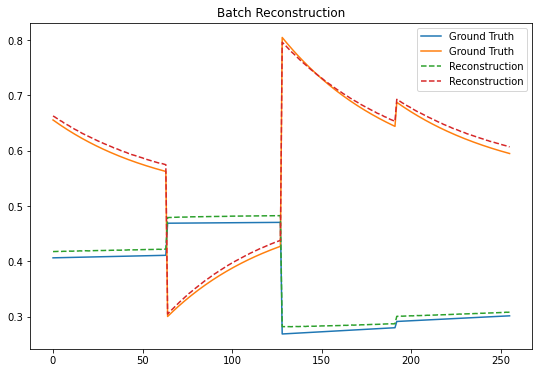

In [ ]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(out1, '--', label="Reconstruction")
plt.legend()

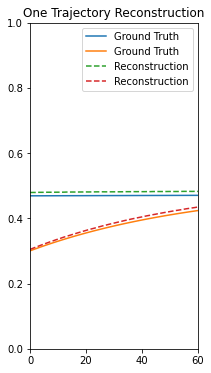

In [ ]:
plt.figure(figsize=(3,6))
plt.plot(input[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out1[trajLength:trajLength*2], '--',label="Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Reconstruction")
plt.legend()

### Linear Prediction

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

In [ ]:
print(np.shape(x))
print(np.shape(x2))
print(np.shape(out3))

In [ ]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(out3, '--', label="Linear Prediction")
plt.legend()

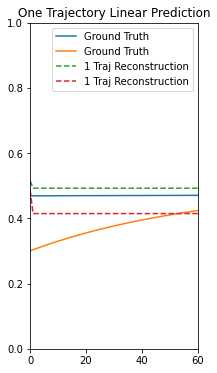

In [ ]:
plt.figure(figsize=(3,6))
plt.plot(x[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out3[trajLength:trajLength*2], '--',label="1 Traj Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Linear Prediction")
plt.legend()

### Koopman Matrix

In [ ]:
K = best_model.koopman.get_weights()

## Save the model

In [ ]:
best_model.save('checkpoints/test_koopman_1')

INFO:tensorflow:Assets written to: checkpoints/test_koopman_1\assets


## Load the model

In [ ]:
new_model = tf.keras.models.load_model('checkpoints/test_koopman_1', compile=False)
new_model.summary()
new_out1, new_out2, out3 = new_model(x_train)
plt.plot(new_out1)
plt.title("New Model Koopman AE Output")

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  1968      
_________________________________________________________________
koopman_model (KoopmanModel) multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  3506      
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
_________________________________________________________________


ValueError: slice index 384 of dimension 0 out of bounds. for '{{node koopman_model/koopman_layer/strided_slice_12}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=2, ellipsis_mask=0, end_mask=2, new_axis_mask=0, shrink_axis_mask=1](encoder_model/activation_4/Relu, koopman_model/koopman_layer/strided_slice_12/stack, koopman_model/koopman_layer/strided_slice_12/stack_1, koopman_model/koopman_layer/strided_slice_12/stack_2)' with input shapes: [50,16], [2], [2], [2] and with computed input tensors: input[1] = <384 0>, input[2] = <385 0>, input[3] = <1 1>.

In [ ]:
new_model.koopmanLayer.get_weights

<bound method Layer.get_weights of <keras.saving.saved_model.load.KoopmanLayer object at 0x000001D6491A17C0>>